# Install Library

In [ ]:
!pip install chart_studio

     |████████████████████████████████| 71kB 4.8MB/s 


# Import Library
## Use Plotly is optional, Plotly chose because we can filter the data to be shown
### You can use Matplotlib as well

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from keras.layers import LSTM
from pathlib import Path

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
import chart_studio
import plotly.express as px
chart_studio.tools.set_credentials_file(username='DerniAgeng', api_key='ZMAguW1HDlV8v7EYvqVJ')

# Data Exploratory
Data Preprocessing For Changyuan Building

In [ ]:
df = pd.read_csv("hotaiLog_2020_07-08.csv", encoding='latin-1')
df2 = pd.read_csv("hotaiLog_2020_0901-1025.csv", encoding='latin-1')
df3 = pd.read_csv('hotaiLog_2020_1026-1217.csv', encoding='latin-1', error_bad_lines=False)
df4 = pd.read_excel('hotaiLog_20201218-20210131.xlsx')
df5 = pd.read_excel('hotaiLog_20210201-20210315.xlsx')
df6 = pd.read_excel('hotaiLog_20210316-20210428.xlsx')
data = pd.concat([df,df2,df3,df4,df5,df6])
data.describe() # 0010033045110b0343000001		

,meterType,slaveAddr,blockId,wire,freq,ua,ub,uc,uln_avg,uab,ubc,uca,ull_avg,ia,ib,ic,i_avg,pa,pb,pc,p_sum,qa,qb,qc,q_sum,sa,sb,sc,s_sum,pfa,pfb,pfc,pf_avg,aea,aeb,aec,ae_tot,rea,reb,rec,re_tot,u1_thd,u2_thd,u3_thd,uavg_thd,i1_thd,i2_thd,i3_thd,iavg_thd,tpd
count,2.698641e+06,2.698641e+06,2.698641e+06,2698641.0,2.698641e+06,781986.0,781965.0,781956.0,781964.000000,781961.000000,782010.000000,782022.000000,397467.000000,782014.00000,782018.000000,782016.000000,782017.000000,7.820190e+05,782004.0,7.818780e+05,2.698641e+06,3.971730e+05,397168.0,3.971440e+05,8.005230e+05,397099.000000,397094.0,397088.000000,8.006090e+05,3.973530e+05,397355.0,3.973730e+05,781925.000000,384544.0,384544.0,384544.0,2.698641e+06,0.0,0.0,0.0,2.396643e+06,483288.000000,397339.000000,397344.0,397356.000000,397367.000000,397374.0,397387.000000,397421.000000,84647.000000
mean,2.177019e+00,1.965843e+00,1.516630e+00,1.0,6.456081e+01,0.0,0.0,0.0,111.072251,111.570775,111.406835,110.303971,6062.928215,5.24336,1.835571,5.119687,5.004227,8.637553e+07,0.0,6.209328e+04,1.016219e+08,2.133314e+08,0.0,5.265128e+08,6.498263e+08,35382.983908,0.0,34026.830859,3.132218e+04,1.691121e+05,0.0,7.660374e+01,15.392318,0.0,0.0,0.0,3.162062e+05,NaN,NaN,NaN,4.479044e+07,1.606913,1.721366,0.0,1.720419,11.293435,0.0,7.440096,10.498072,28857.933276
std,1.252464e+00,1.210409e+00,2.226821e+00,0.0,5.457726e+01,0.0,0.0,0.0,112.923176,113.377262,113.217001,112.097105,5590.687540,15.90533,8.410463,15.789848,15.381504,4.219273e+08,0.0,1.001345e+07,4.559102e+08,6.422959e+08,0.0,9.238159e+08,9.864937e+08,80334.309718,0.0,80419.236426,1.021912e+05,5.784167e+05,0.0,1.274640e+04,26.753029,0.0,0.0,0.0,4.734835e+05,NaN,NaN,NaN,8.723384e+07,0.845798,0.780152,0.0,0.781872,14.739533,0.0,16.092032,14.267198,28073.118415
min,1.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,216.200000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,4.000000e-03,0.000000,0.0,0.0,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,523.000000
25%,1.000000e+00,1.000000e+00,0.000000e+00,1.0,5.996000e+01,0.0,0.0,0.0,0.000000,0.100000,0.100000,0.100000,224.200000,0.00000,0.000000,0.000000,0.053000,0.000000e+00,0.0,0.000000e+00,2.280000e+02,0.000000e+00,0.0,0.000000e+00,3.400000e+01,0.000000,0.0,0.000000,9.900000e+01,5.650000e-01,0.0,9.050000e-01,0.930000,0.0,0.0,0.0,2.504600e+04,NaN,NaN,NaN,1.615400e+03,1.500000,1.600000,0.0,1.600000,0.000000,0.0,0.000000,0.000000,3942.000000
50%,3.000000e+00,2.000000e+00,0.000000e+00,1.0,6.000000e+01,0.0,0.0,0.0,0.000000,0.100000,0.100000,0.100000,10937.900000,0.21900,0.000000,0.164000,0.282000,0.000000e+00,0.0,0.000000e+00,3.508000e+03,7.151000e+03,0.0,0.000000e+00,6.996000e+03,5535.000000,0.0,0.000000,1.230000e+03,8.780000e-01,0.0,1.000000e+00,1.000000,0.0,0.0,0.0,6.794970e+04,NaN,NaN,NaN,1.475120e+04,1.900000,1.900000,0.0,1.900000,7.400000,0.0,0.000000,7.300000,16134.000000
75%,3.000000e+00,2.000000e+00,2.000000e+00,1.0,6.003000e+01,0.0,0.0,0.0,225.900000,226.800000,226.500000,224.300000,11551.700000,2.92575,1.584000,3.009000,3.164000,2.117000e+03,0.0,0.000000e+00,2.456300e+04,6.279700e+04,0.0,1.925595e+05,2.147484e+09,25347.500000,0.0,20357.000000,1.123900e+04,1.000000e+00,0.0,1.000000e+00,1.000000,0.0,0.0,0.0,4.309054e+05,NaN,NaN,NaN,6.801160e+04,2.100000,2.100000,0.0,2.200000,16.400000,0.0,8.400000,14.200000,50267.000000
max,5.000000e+00,7.000000e+00,8.000000e+00,1.0,6.553500e+02,0.0,0.0,0.0,233.600000,234.800000,234.100000,231.700000,12126.500000,256.82500,179.872000,258.035000,277.643000,2.147484e+09,0.0,2.147484e+09,2.147484e+09,2.147484e+09,0.0,2.147484e+09,2.147484e+09,788292.000000,0.0,787502.000000,1.364019e+06,2.147484e+06,0.0,2.147484e+06,65.535000,0.0,0.0,0.0,1.941646e+06,NaN,NaN,NaN,2.147484e+08,5.700000,5.600000,0.0,5.500000,138.700000,0.0,146.2000

In [ ]:
s = data[data['equipmentId'].isin(['0010033045110b0343000001'])]

Separate each blockId

In [ ]:
s1 = s[s['blockId'].isin(['1'])]
s2 = s[s['blockId'].isin(['2'])]

In [ ]:
s2.head()

,IoTHubDeviceId,equipmentId,meterType,lastReportTime,slaveAddr,blockId,wire,freq,ua,ub,uc,uln_avg,uab,ubc,uca,ull_avg,ia,ib,ic,i_avg,pa,pb,pc,p_sum,qa,qb,qc,q_sum,sa,sb,sc,s_sum,pfa,pfb,pfc,pf_avg,aea,aeb,aec,ae_tot,rea,reb,rec,re_tot,u1_thd,u2_thd,u3_thd,uavg_thd,i1_thd,i2_thd,i3_thd,iavg_thd,CreatedAt,tpd
74858,0010033045110b0343000000,0010033045110b0343000001,4.0,2020-07-15 00:04:12,1.0,2.0,1.0,59.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,730.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9265.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 00:04:26.350000000,NaN
74859,0010033045110b0343000000,0010033045110b0343000001,4.0,2020-07-15 00:04:13,1.0,2.0,1.0,59.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9265.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 00:04:26.893000000,NaN
74892,0010033045110b0343000000,0010033045110b0343000001,4.0,2020-07-15 00:09:12,1.0,2.0,1.0,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9265.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 00:09:23.017000000,NaN
74893,0010033045110b0343000000,0010033045110b0343000001,4.0,2020-07-15 00:09:13,1.0,2.0,1.0,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9265.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 00:09:23.563000000,NaN
74929,0010033045110b0343000000,0010033045110b0343000001,4.0,2020-07-15 00:14:13,1.0,2.0,1.0,60.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9266.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 00:14:19.620000000,NaN


Check missing percentage

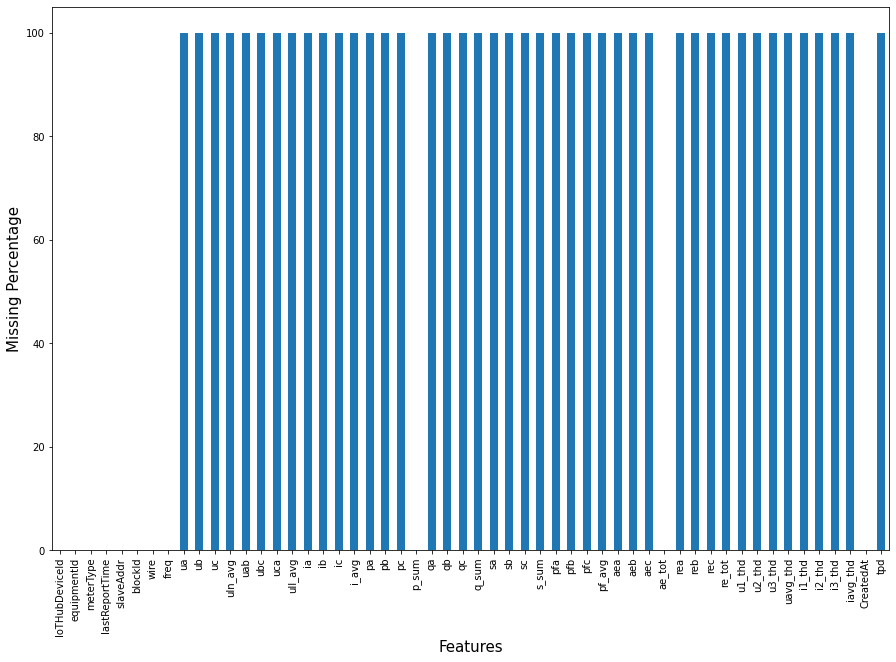

In [ ]:
missing_value = s2.isna().mean() * 100
missing_value.plot(kind='bar', figsize=(15,10))
plt.ylabel('Missing Percentage', size=15)
plt.xlabel('Features', size=15)
plt.show()

In [ ]:
s2.isna().mean()

IoTHubDeviceId    0.0
equipmentId       0.0
meterType         0.0
lastReportTime    0.0
slaveAddr         0.0
blockId           0.0
wire              0.0
freq              0.0
ua                1.0
ub                1.0
uc                1.0
uln_avg           1.0
uab               1.0
ubc               1.0
uca               1.0
ull_avg           1.0
ia                1.0
ib                1.0
ic                1.0
i_avg             1.0
pa                1.0
pb                1.0
pc                1.0
p_sum             0.0
qa                1.0
qb                1.0
qc                1.0
q_sum             1.0
sa                1.0
sb                1.0
sc                1.0
s_sum             1.0
pfa               1.0
pfb               1.0
pfc               1.0
pf_avg            1.0
aea               1.0
aeb               1.0
aec               1.0
ae_tot            0.0
rea               1.0
reb               1.0
rec               1.0
re_tot            1.0
u1_thd            1.0
u2_thd    

Drop columns that has missing percentage greater than 30%

In [ ]:
s1 = s1.loc[:, s1.isna().mean() < .30]
s2 = s2.loc[:, s2.isna().mean() < .30]
s1.columns

Index(['IoTHubDeviceId', 'equipmentId', 'meterType', 'lastReportTime',
       'slaveAddr', 'blockId', 'wire', 'freq', 'p_sum', 'ae_tot', 'CreatedAt'],
      dtype='object')

Separate Numerical Columns

In [ ]:
vars_num_anom = [var for var in s1.columns if s1[var].dtypes != 'O']
s1[vars_num_anom].head()

,meterType,slaveAddr,blockId,wire,freq,p_sum,ae_tot
74856,4.0,1.0,1.0,1.0,59.96,610.0,2371.2
74857,4.0,1.0,1.0,1.0,59.95,630.0,2371.2
74890,4.0,1.0,1.0,1.0,60.06,730.0,2371.2
74891,4.0,1.0,1.0,1.0,60.06,710.0,2371.2
74927,4.0,1.0,1.0,1.0,60.07,670.0,2371.3


Handle the overflow value

In [ ]:
s1[vars_num_anom] = s1[vars_num_anom].replace(
    {2147483647:np.NaN})
s2[vars_num_anom] = s2[vars_num_anom].replace(
    {2147483647:np.NaN})

In [ ]:
s2.isna().mean()*100

IoTHubDeviceId    0.0
equipmentId       0.0
meterType         0.0
lastReportTime    0.0
slaveAddr         0.0
blockId           0.0
wire              0.0
freq              0.0
p_sum             0.0
ae_tot            0.0
CreatedAt         0.0
dtype: float64

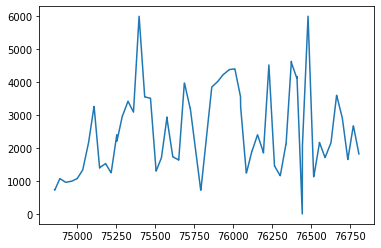

In [ ]:
s2['p_sum'][:100].plot()

# Resample each ID dataset into hourly 

In [ ]:
s1['lastReportTime'] = pd.to_datetime(s1['lastReportTime'], errors='coerce')
s1.set_index('lastReportTime', inplace=True)
s1 = s1.resample('h').mean()
s1 = s1.reset_index()
s2['lastReportTime'] = pd.to_datetime(s2['lastReportTime'], errors='coerce')
s2.set_index('lastReportTime', inplace=True)
s2 = s2.resample('h').mean()
s2 = s2.reset_index()
s1.head()

,lastReportTime,meterType,slaveAddr,blockId,wire,freq,p_sum,ae_tot
0,2020-07-15 00:00:00,4.0,1.0,1.0,1.0,60.012727,935.454545,2371.554545
1,2020-07-15 01:00:00,4.0,1.0,1.0,1.0,60.010000,1614.090909,2373.059091
2,2020-07-15 02:00:00,4.0,1.0,1.0,1.0,60.017500,1943.000000,2374.485000
3,2020-07-15 03:00:00,4.0,1.0,1.0,1.0,59.987895,1462.105263,2375.947368
4,2020-07-15 04:00:00,4.0,1.0,1.0,1.0,59.997917,1569.583333,2377.508333


In [ ]:
s2.isna().mean()

lastReportTime    0.000000
meterType         0.158709
slaveAddr         0.158709
blockId           0.158709
wire              0.158709
freq              0.158709
p_sum             0.158709
ae_tot            0.158709
dtype: float64

# Data Imputation

In [ ]:
s1= s1.interpolate()
s2= s2.interpolate()

In [ ]:
s2.isna().mean()

lastReportTime    0.0
meterType         0.0
slaveAddr         0.0
blockId           0.0
wire              0.0
freq              0.0
p_sum             0.0
ae_tot            0.0
dtype: float64

# Feature Engineering

In [ ]:
s1['lastReportTime'] = pd.to_datetime(s1['lastReportTime'], errors='coerce')
s1 = s1.assign(session=pd.cut(s1['lastReportTime'].dt.hour,[0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening']))
s2['lastReportTime'] = pd.to_datetime(s2['lastReportTime'], errors='coerce')
s2 = s2.assign(session=pd.cut(s2['lastReportTime'].dt.hour,[0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening']))

In [ ]:
s1['session'] = s1['session'].cat.add_categories('Midnight')
s1['session'] = s1['session'].fillna('Midnight')
s2['session'] = s2['session'].cat.add_categories('Midnight')
s2['session'] = s2['session'].fillna('Midnight')

In [ ]:
s1['session'] = s1['session'].replace({'Night':0,'Midnight':1,'Morning':2,'Afternoon':3,'Evening':4})
s2['session'] = s2['session'].replace({'Night':0,'Midnight':1,'Morning':2,'Afternoon':3,'Evening':4})

In [ ]:
s1['weekend'] = np.where((s1['lastReportTime']).dt.dayofweek < 5,0,1)
s2['weekend'] = np.where((s2['lastReportTime']).dt.dayofweek < 5,0,1)

## Add temperature Dataset

In [ ]:
d_two = pd.read_csv('Taipei_temperature_202007-202104.csv',sep=',',engine='python')

In [ ]:
d_two['lastReportTime'] = pd.to_datetime(d_two['lastReportTime'], errors='coerce')
d_two = d_two[['Temperature', 'lastReportTime']]

In [ ]:
d_two.set_index('lastReportTime', inplace = True)
d_two = d_two.resample('h').mean()
d_two = d_two.reset_index()
d_two.head()

,lastReportTime,Temperature
0,2020-07-01 00:00:00,27.2
1,2020-07-01 01:00:00,29.1
2,2020-07-01 02:00:00,28.9
3,2020-07-01 03:00:00,28.6
4,2020-07-01 04:00:00,28.5


In [ ]:
sid1 = pd.merge(s1, d_two, left_on='lastReportTime', right_on='lastReportTime')
sid2 = pd.merge(s2, d_two, left_on='lastReportTime', right_on='lastReportTime')

In [ ]:
sid1.head()

,lastReportTime,meterType,slaveAddr,blockId,wire,freq,p_sum,ae_tot,session,weekend,Temperature
0,2020-07-15 00:00:00,4.0,1.0,1.0,1.0,60.012727,935.454545,2371.554545,1,0,29.6
1,2020-07-15 01:00:00,4.0,1.0,1.0,1.0,60.010000,1614.090909,2373.059091,0,0,30.4
2,2020-07-15 02:00:00,4.0,1.0,1.0,1.0,60.017500,1943.000000,2374.485000,0,0,30.2
3,2020-07-15 03:00:00,4.0,1.0,1.0,1.0,59.987895,1462.105263,2375.947368,0,0,29.9
4,2020-07-15 04:00:00,4.0,1.0,1.0,1.0,59.997917,1569.583333,2377.508333,0,0,29.8


In [ ]:
sid1['equipmentId'] = '0010033045110b0343000001'
sid2['equipmentId'] = '0010033045110b0343000002'

In [ ]:
sid1.to_csv('S1_Interpolation_Full_202007-202104.csv')
sid2.to_csv('S2_Interpolation_Full_202007-202104.csv')


# Merge all id into one dataset

In [ ]:
combine = pd.concat([sid1,sid2])
combine

,lastReportTime,meterType,slaveAddr,blockId,wire,freq,p_sum,ae_tot,session,weekend,Temperature,equipmentId
0,2020-07-15 00:00:00,4.0,1.0,1.0,1.0,60.012727,935.454545,2371.554545,1,0,29.6,0010033045110b0343000001
1,2020-07-15 01:00:00,4.0,1.0,1.0,1.0,60.010000,1614.090909,2373.059091,0,0,30.4,0010033045110b0343000001
2,2020-07-15 02:00:00,4.0,1.0,1.0,1.0,60.017500,1943.000000,2374.485000,0,0,30.2,0010033045110b0343000001
3,2020-07-15 03:00:00,4.0,1.0,1.0,1.0,59.987895,1462.105263,2375.947368,0,0,29.9,0010033045110b0343000001
4,2020-07-15 04:00:00,4.0,1.0,1.0,1.0,59.997917,1569.583333,2377.508333,0,0,29.8,0010033045110b0343000001
...,...,...,...,...,...,...,...,...,...,...,...,...
6907,2021-04-28 19:00:00,4.0,1.0,2.0,1.0,60.044167,0.000000,13244.200000,4,0,18.4,0010033045110b0343000002
6908,2021-04-28 20:00:00,4.0,1.0,2.0,1.0,60.023333,0.000000,13244.200000,4,0,18.4,0010033045110b0343000002
6909,2021-04-28 21:00:00,4.0,1.0,2.0,1.0,59.990833,0.000000,13244.200000,4,0,18.3,0010033045110b0343000002
6910,2021-04-28 22:00:00,4.0,1.0,2.0,1.0,60.006667,49.166667,13244.200000,4,0,18.4,0010033045110b0343000002


In [ ]:
combine['lastReportTime'] = pd.to_datetime(combine['lastReportTime'], errors='coerce')
combine.set_index('lastReportTime', inplace=True)
combine = combine.resample('h').mean()
combine = combine.reset_index()
combine.head()

,lastReportTime,meterType,slaveAddr,blockId,wire,freq,p_sum,ae_tot,session,weekend,Temperature
0,2020-07-15 00:00:00,4.0,1.0,1.5,1.0,60.013239,1218.977273,5432.898106,1,0,29.6
1,2020-07-15 01:00:00,4.0,1.0,1.5,1.0,60.010476,2211.735931,5821.043831,0,0,30.4
2,2020-07-15 02:00:00,4.0,1.0,1.5,1.0,60.013750,2538.500000,5822.917500,0,0,30.2
3,2020-07-15 03:00:00,4.0,1.0,1.5,1.0,59.988197,1989.027632,5129.333684,0,0,29.9
4,2020-07-15 04:00:00,4.0,1.0,1.5,1.0,59.998750,2076.041667,5826.947917,0,0,29.8


# Save as a new dataset

In [44]:
combine.to_csv('solarbuilding_interpolation_202007-202104.csv')
combine

,lastReportTime,meterType,slaveAddr,blockId,wire,freq,p_sum,ae_tot,session,weekend,Temperature
0,2020-07-15 00:00:00,4.0,1.0,1.5,1.0,60.013239,1218.977273,5432.898106,1,0,29.6
1,2020-07-15 01:00:00,4.0,1.0,1.5,1.0,60.010476,2211.735931,5821.043831,0,0,30.4
2,2020-07-15 02:00:00,4.0,1.0,1.5,1.0,60.013750,2538.500000,5822.917500,0,0,30.2
3,2020-07-15 03:00:00,4.0,1.0,1.5,1.0,59.988197,1989.027632,5129.333684,0,0,29.9
4,2020-07-15 04:00:00,4.0,1.0,1.5,1.0,59.998750,2076.041667,5826.947917,0,0,29.8
...,...,...,...,...,...,...,...,...,...,...,...
6907,2021-04-28 19:00:00,4.0,1.0,1.5,1.0,60.044167,32758.125000,9392.350000,4,0,18.4
6908,2021-04-28 20:00:00,4.0,1.0,1.5,1.0,60.023333,32758.291667,9392.350000,4,0,18.4
6909,2021-04-28 21:00:00,4.0,1.0,1.5,1.0,59.991250,32758.125000,9392.350000,4,0,18.3
6910,2021-04-28 22:00:00,4.0,1.0,1.5,1.0,60.011250,32782.541667,9392.350000,4,0,18.4


In [ ]:
fig = go.Figure(go.Scatter(y=combine['p_sum'], name = 'old'))
# fig.add_scatter(y=combine['p_sum'], name = 'new')
fig.update_layout(title_text = 'Plot', xaxis_title = 'N data', yaxis_title = 'W')